In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
pwd

'/content/gdrive/MyDrive/Colab Notebooks'

In [3]:
%cd /content/gdrive/MyDrive/Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [6]:
ls

kaggle.json  plantdisease.zip  Untitled0.ipynb  Untitled3.ipynb


In [7]:
import zipfile
with zipfile.ZipFile('plantdisease.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/plantdisease')

In [9]:
import os
data_dir = '/content/plantdisease/PlantVillage'
os.listdir(data_dir)

['Tomato_Septoria_leaf_spot',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Bacterial_spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Late_blight',
 'Tomato_healthy',
 'Pepper__bell___Bacterial_spot',
 'Potato___Early_blight',
 'Potato___healthy',
 'Pepper__bell___healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato_Early_blight',
 'Potato___Late_blight']

In [10]:
# Import Basic Library
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [11]:
folder_path = '/content/plantdisease/PlantVillage'
classes = os.listdir(folder_path)
num_classes = len(classes)
print("Number of classes:", num_classes)
print(classes)

Number of classes: 15
['Tomato_Septoria_leaf_spot', 'Tomato_Leaf_Mold', 'Tomato__Tomato_mosaic_virus', 'Tomato_Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Late_blight', 'Tomato_healthy', 'Pepper__bell___Bacterial_spot', 'Potato___Early_blight', 'Potato___healthy', 'Pepper__bell___healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato_Early_blight', 'Potato___Late_blight']


In [12]:
class_counts = {}
dataset_path = '/content/plantdisease/PlantVillage'
class_folders = os.listdir(dataset_path)
for class_name in class_folders:
    class_folder_path = os.path.join(dataset_path, class_name)
    class_counts[class_name] = len(os.listdir(class_folder_path))

# Print the number of images per class
for class_name, count in class_counts.items():
    print(f"Class {class_name}: {count} images")

Class Tomato_Septoria_leaf_spot: 1771 images
Class Tomato_Leaf_Mold: 952 images
Class Tomato__Tomato_mosaic_virus: 373 images
Class Tomato_Bacterial_spot: 2127 images
Class Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 images
Class Tomato_Late_blight: 1909 images
Class Tomato_healthy: 1591 images
Class Pepper__bell___Bacterial_spot: 997 images
Class Potato___Early_blight: 1000 images
Class Potato___healthy: 152 images
Class Pepper__bell___healthy: 1478 images
Class Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Class Tomato__Target_Spot: 1404 images
Class Tomato_Early_blight: 1000 images
Class Potato___Late_blight: 1000 images


In [13]:
import shutil
from sklearn.model_selection import train_test_split

dataset_path = '/content/plantdisease/PlantVillage'
output_path = '/content/plantdisease/Output'

classes = os.listdir(dataset_path)

# Parameters
test_size = 0.2  # 20% for test set
val_size = 0.2  # 20% of the remaining 80% for the validation set

# Function to copy files
def copy_files(files, source, dest):
    os.makedirs(dest, exist_ok=True)
    for file in files:
        file_path = os.path.join(source, file)
        if os.path.isfile(file_path):  # Ensure it's a file, not a directory
            shutil.copy(file_path, dest)

# Splitting and copying the dataset
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    # Splitting
    train_val, test = train_test_split(images, test_size=test_size, random_state=42)
    train, val = train_test_split(train_val, test_size=val_size, random_state=42)

    # Copying files
    for dataset_type, dataset_files in zip(['train', 'val', 'test'], [train, val, test]):
        dest_path = os.path.join(output_path, dataset_type, class_name)
        copy_files(dataset_files, class_path, dest_path)

print("Dataset successfully split into training, validation, and test sets.")

Dataset successfully split into training, validation, and test sets.


In [31]:
# Preprocessing Images by ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_dir = '/content/plantdisease/Output/train'
validation_data_dir = '/content/plantdisease/Output/val'


batch_size = 32
img_width, img_height = 100, 100

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

# Validation data should not be augmented
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Flow validation images in batches
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 13196 images belonging to 15 classes.
Found 3308 images belonging to 15 classes.


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model parameters
num_classes = 15
# img_width, img_height = 256, 256

# Initialize the model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(2, 2))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Fourth Convoltional Layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flattening
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

# Dropout to prevent overfitting
model.add(Dropout(0.3))
# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,506,895 (5.75 MB)

 Trainable params: 1,506,895 (5.75 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
epochs = 5

historyCNN = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

Epoch 1/5
412/412 ━━━━━━━━━━━━━━━━━━━━ 368s 884ms/step - accuracy: 0.2282 - loss: 2.3489 - val_accuracy: 0.3695 - val_loss: 2.1144
Epoch 2/5
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 229us/step - accuracy: 0.5000 - loss: 1.6348 - val_accuracy: 0.2500 - val_loss: 2.7504
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


412/412 ━━━━━━━━━━━━━━━━━━━━ 378s 874ms/step - accuracy: 0.4858 - loss: 1.5670 - val_accuracy: 0.5731 - val_loss: 1.2851
Epoch 4/5
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 194us/step - accuracy: 0.6875 - loss: 1.0378 - val_accuracy: 0.5833 - val_loss: 1.2340
Epoch 5/5
412/412 ━━━━━━━━━━━━━━━━━━━━ 360s 872ms/step - accuracy: 0.6290 - loss: 1.1290 - val_accuracy: 0.6035 - val_loss: 1.2737


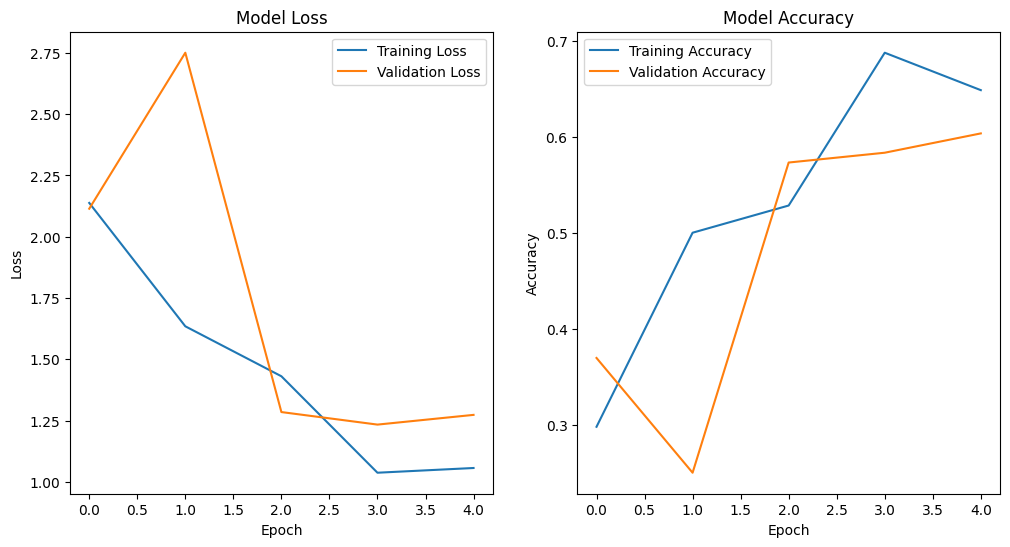

In [34]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(historyCNN.history['loss'], label='Training Loss')
plt.plot(historyCNN.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(historyCNN.history['accuracy'], label='Training Accuracy')
plt.plot(historyCNN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [35]:
model.save('PlantVillage1002.h5')

In [36]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks


In [37]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model("/content/gdrive/MyDrive/Colab Notebooks/PlantVillage.h5")
# Load an image for prediction (replace 'path_to_your_image.jpg' with the actual path)
img_path = "/content/plantdisease/PlantVillage/Tomato_Late_blight/0566e4e3-675b-4289-9e36-ad199448975b___GHLB2 Leaf 161.2.JPG"
img = image.load_img(img_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Normalize the image data
img_array /= 255.

# Predict the class probabilities for the input image
class_probabilities = model.predict(img_array)

# Get the predicted class label
predicted_label = np.argmax(class_probabilities)

# Map class index to class label (assuming you have a list of class labels)
class_labels = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
predicted_label_name = class_labels[predicted_label]

print("Predicted label:", predicted_label_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Predicted label: Tomato_Bacterial_spot
